In [1]:
import numpy as np
import pandas as pd
# Algorítimos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, plot_roc_curve, auc, roc_curve, roc_auc_score, confusion_matrix
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, KFold
from nested_cv import NestedCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [2]:
descritores = "morgan"
#descritores = "sirms"
#descritores = "rdkit"
seed = 42
# limiar
threshold = 0.8

In [3]:
# Create an object for StratifiedKFold cross-validation
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [4]:
from sklearn import metrics

def stats(y_test, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    Kappa = metrics.cohen_kappa_score(y_test, y_pred, weights='linear')
    # Valores verdadeiros e falsos
    TN, FP, FN, TP = confusion_matrix.ravel()
    # Accuracy
    AC = (TP+TN)/(TP+FP+FN+TN)
    # Sensibilidade, taxa de acerto, recall ou taxa positiva verdadeira
    SE = TP/(TP+FN)
    # Especificidade ou taxa negativa verdadeira
    SP = TN/(TN+FP)
    # Precisão ou valor preditivo positivo
    PPV = TP/(TP+FP)
    # Valor preditivo negativo
    NPV = TN/(TN+FN)
    # Taxa de classificação correta
    CCR = (SE + SP)/2   
    # F1 Score
    F1_score = 2*(PPV*SE)/(PPV+SE)
    d = dict({'Kappa': Kappa,
         'AUC': CCR,
         'Sensibilidade': SE,
         'PPV': PPV,
         'Especificidade': SP,
         'NPV': NPV,
         'Acurácia': AC,
         'F1 Score':F1_score})
    return pd.DataFrame(d, columns=d.keys(), index=[0]).round(2)

In [5]:
from sklearn.metrics import classification_report, roc_auc_score

def report(model, y_test, y_pred, y_prob, algoritmo, descritores):
    # imprimir relatório de classificação
    print("Relatório de Classificação - " + descritores + "X" + algoritmo + ":\n", classification_report(y_test, y_pred, digits=4))
    # imprimir a área sob a curva
    print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_prob[:, 1])))

In [6]:
def confusion_mtx(y_pred, y_test, algoritimo, descritores):
    fig, ax = plt.subplots()
    cm = metrics.confusion_matrix(y_test, y_pred)
    print('confusion_matrix:')
    print(cm)
    sns.heatmap(cm, annot=True, 
                ax=ax, fmt='d', cmap='Reds')
    ax.set_title("Matriz de Confusão - "+descritores+'X'+algoritimo, fontsize=18)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted Label")
    plt.savefig('figures/'+descritores+'X'+algoritimo+'confusion-matrix.png', bbox_inches='tight',
                transparent=False, format='png', dpi=300)
    plt.tight_layout()

In [7]:
def precisao_recall(y_pred, y_test, algoritimo, descritores):
    pos_probs = y_pred[:, 1]
   
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, pos_probs)
    print('precisions:')
    print(precisions)
    print('recalls:')
    print(recalls)
    print('thresholds:')
    print(thresholds)
    fig, ax = plt.subplots(figsize = (12,3))
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precisão')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'center right')
    plt.ylim([0,1])
    plt.title('Precisão x Recall - '+descritores+'X'+algoritimo, fontsize = 14)
    plt.savefig('figures/'+descritores+'X'+algoritimo+'precisao-recall.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
    plt.show()

In [8]:
def validation(y_ts, x_ts, cross_val, m):
    # Params
    pred = []
    ad = []
    index = []
    df_ts = pd.DataFrame(x_ts)

    # Do 5-fold loop
    for train_index, test_index in cross_val.split(df_ts, y_ts):

        fold_model = m.fit(df_ts.iloc[train_index], y_ts[train_index])
        fold_pred = m.predict(df_ts.iloc[test_index])
        fold_ad = m.predict_proba(df_ts.iloc[test_index])
        pred.append(fold_pred)
        ad.append(fold_ad)
        index.append(test_index)

    threshold_ad = 0.80

    # Prepare results to export    
    fold_index = np.concatenate(index)    
    fold_pred = np.concatenate(pred)
    fold_ad = np.concatenate(ad)
    fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
    five_fold_model = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
    five_fold_model.AD[five_fold_model.AD == 'False'] = np.nan
    five_fold_model.AD[five_fold_model.AD == 'True'] = five_fold_model.Prediction
    five_fold_model.sort_index(inplace=True)
    five_fold_model['y_train'] = pd.DataFrame(y_ts)
    five_fold_model_ad = five_fold_model.dropna().astype(int)
    coverage_5f = len(five_fold_model_ad) / len(five_fold_model)

    # model stats
    model = pd.DataFrame(stats(five_fold_model['y_train'], five_fold_model['Prediction']))
    model['Coverage'] = 1.0

    # model AD stats
    model_ad = five_fold_model.dropna(subset=['AD']).astype(int)
    coverage_model_ad = len(model_ad['AD']) / len(five_fold_model['y_train'])
    model_ad = pd.DataFrame(stats(model_ad['y_train'], model_ad['AD']))
    model_ad['Coverage'] = round(coverage_model_ad, 2)

    # print stats
    print('\033[1m' + '5-fold External Cross Validation Statistical Characteristcs of QSAR models developed '+descritores+ '\n' + '\033[0m')
    model_5f_stats = model.append(model_ad)
    model_5f_stats.set_index([[descritores, descritores+' AD']], drop=True, inplace=True)
    return model_5f_stats

In [9]:
def get_best_model_with_random_search(y_train, X_train, param_dist, cross_val, algoritimo, seed):
    
    random_search = RandomizedSearchCV(estimator = algoritimo, 
                                       param_distributions = param_dist, 
                                       n_iter=10, 
                                       cv = cross_val, 
                                       random_state=seed, 
                                       n_jobs = None)
    random_search.fit(X_train, y_train)

    print(f"best_estimator: -> {random_search.best_estimator_}")
    print(f"cv_results: -> {random_search.cv_results_}")
    print(f"best_params: -> {random_search.best_params_}")
    print(f"best_score: -> {random_search.best_score_}")
    print(f"params: -> {random_search.cv_results_['params']}")
    print(f"mean_test_score: -> {random_search.cv_results_['mean_test_score']}")

    return random_search

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def print_stats(morgan_stats, algoritimo, descritores):
    # Estatísticas de transposição
    morgan_stats_t = morgan_stats.T
    morgan_stats_t = morgan_stats_t.reset_index()
    morgan_stats_t = morgan_stats_t.rename(columns={'index': 'Stats'})

    # Fazer enredo
    plt.style.use('seaborn-colorblind')
    fig, ax1 = plt.subplots(figsize=(10,6))

    morgan_stats_t.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_xticklabels(labels=morgan_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
    ax1.axhline(y=.8, color='indianred', ls='dashed')# xmin=0.25, xmax=0.75)
    ax1.legend_.remove()
    plt.title('Características estatísticas - '+descritores+'X'+algoritimo, fontsize=16)
    ax1.set_yticks(np.arange(0, 1.1, 0.1))
    ax1.tick_params(labelsize=12)

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, fontsize=16,
                loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True,
                shadow=True, ncol=2)
    fig.tight_layout()

    plt.savefig('figures/'+descritores+'X'+algoritimo+'statistics-'+descritores+'.png', bbox_inches='tight',
                transparent=False, format='png', dpi=300)
    plt.show();

In [11]:
from sklearn.model_selection import permutation_test_score
import pandas as pd
import numpy as np
import pylab as pl
from rdkit import Chem
from math import floor
import matplotlib.pyplot as plt

# Avaliar a significância de uma pontuação validada cruzada com permutações
# True score = A pontuação verdadeira, sem permutar metas.
# Y-randomization = Media das pontuações obtidas para cada permutação.
# np-value = O valor retornado é igual ao valor-p se a pontuação retornar números maiores para obter melhores 
#     pontuações (por exemplo, exatidão_score). Se a pontuação é uma função de perda (ou seja, quando menor é melhor, 
#     como com mean_squared_error), então esse é realmente o complemento do valor p: 1 - valor p.
##### Função utilitária para relatar as melhores pontuações
def y_randomization(clf, X_test, y_test, descriptor, algoritimo, cross_val):    
    X_test = pd.DataFrame(X_test)
    y_test = np.ravel(y_test)
    
    permutations = 10
    score, permutation_scores, pvalue = permutation_test_score(clf, X_test, y_test,
                                                               cv=cross_val, scoring='balanced_accuracy',
                                                               n_permutations=permutations,
                                                               n_jobs=-1,
                                                               verbose=1,
                                                               random_state=seed)
    print('True score = ', score.round(2),
          '\n Média per. = ', np.mean(permutation_scores).round(2),
          '\np-value = ', pvalue.round(4))

    ###############################################################################
    # View histogram of permutation scores
    pl.subplots(figsize=(10,6))
    pl.hist(permutation_scores.round(2), label='Permutation scores')
    ylim = pl.ylim()
    pl.vlines(score, ylim[0], ylim[1], linestyle='--',
              color='g', linewidth=3, label='Classification Score'
              ' (pvalue %s)' % pvalue.round(4))
    pl.vlines(1.0 / 2, ylim[0], ylim[1], linestyle='--',
              color='k', linewidth=3, label='Luck')
    pl.ylim(ylim)
    pl.legend()
    pl.xlabel('Score')
    pl.title('Aleatoriarização da variável Y '+algoritimo+'X'+descriptor, fontsize=12)
    pl.savefig('figures/y_randomization-'+descriptor+'X'+algoritimo+'.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
    pl.show()

In [12]:
 def roc_auc(rf_best, cross_val, X_train, y_train, algoritimo, descritores):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    X_train = pd.DataFrame(X_train)

    fig, ax = plt.subplots(figsize=(10,6))
    for i, (train_index, test_index) in enumerate(cross_val.split(X_train, y_train)):
        rf_best.fit(X_train.iloc[train_index], y_train[train_index])
        viz = plot_roc_curve(rf_best, X_train.iloc[test_index], y_train[test_index],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8, )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Média ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Característica operacional do receptor "+descritores+"-"+algoritimo)
    ax.legend(loc="lower right")
    plt.savefig('figures/'+descritores+'X'+algoritimo+'roc-auc.png', bbox_inches='tight',
    transparent=False, format='png', dpi=300)
    
    plt.show()

### Lendo moléculas e atividade de SDF

In [13]:
from rdkit.Chem import PandasTools
from collections import Counter
## Carregar dados
def carregar_dados():
    # Definir caminho do arquivo
    file = '../dataset/formats/df_ready_classification.sdf'

       # Novo dicionário inicializado a partir de um objeto de mapeamento
    sdfInfo = dict(smilesName='SMILES', molColName='ROMol')

    # Carregando o arquivo SDF com os dicionarios mapeados
    moldf = PandasTools.LoadSDF(file, **sdfInfo)
    print('Original data: ', moldf.shape)

    # Renomear ROMol
    moldf = moldf.rename(columns={'ROMol': 'Mol'})

    # Remover moléculas RDKit ausentes
    moldf = moldf[pd.notnull(moldf['Mol'])]
    if 'StandardizerResult' in moldf.columns:
        moldf = moldf.drop(columns='StandardizerResult')

    # Colunas
    print('Dados mantidos: ', moldf.shape)

    # Substituir 'active' por 1 e 'inactive' por 0
    moldf['Outcome'] = moldf['bioactivity_class'].replace({'active': 1, 'inactive': 0})

    classes = Counter(moldf['Outcome'])
    print('Class labels:', np.unique(classes))
  
    return moldf

Original data:  (4829, 19)
Dados mantidos:  (4829, 19)
Class labels: [Counter({1: 2841, 0: 1988})]


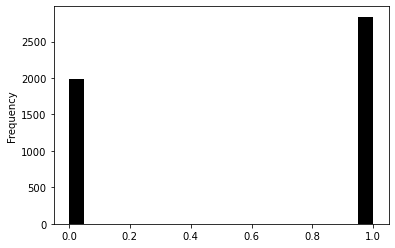

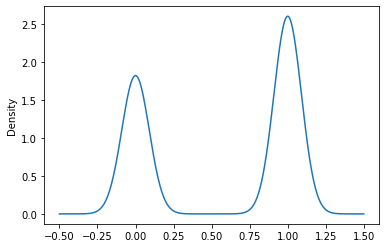

In [14]:
moldf = carregar_dados();

moldf.plot(kind="hist", legend=None, bins=20, color='k')
moldf.plot(kind="kde", legend=None);

In [15]:
moldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4829 entries, 0 to 4828
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Unnamed: 0                           4829 non-null   object
 1   HD                                   4829 non-null   object
 2   HA                                   4829 non-null   object
 3   logP                                 4829 non-null   object
 4   MW                                   4829 non-null   object
 5   lit                                  4829 non-null   object
 6   sum                                  4829 non-null   object
 7   Unnamed: 0.1                         4829 non-null   object
 8   bioactivity_class                    4829 non-null   object
 9   molecule_chembl_id                   4829 non-null   object
 10  canonical_smiles                     4829 non-null   object
 11  Peso Molecular                       4829 n

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from math import floor
#Rdkit: coleção de quiminformática e software de aprendizado de máquina escrito em C++ e Python de Código Aberto.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from collections import Counter

def morgan_descriptors(moldf):   
    moldf['Outcome'] = moldf['Outcome'].replace('active', 1)
    moldf['Outcome'] = moldf['Outcome'].replace('inactive', 0)

    classes = Counter(moldf['Outcome'])
    print('\033[1m' + 'Forma do conjunto de treinamento:' + '\n' + '\033[0m')
    for key, value in classes.items():
        print('\t\t Classe %d: %d' % (key, value))
    print('\t\t Número total de compostos: %d' % (len(moldf['Outcome'])))

    print('Class labels:', np.unique(classes))
    
    # Calculando os descritores fingerprints de Harry Morgan (vetores de bits).
    def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
        fp = pd.Series(np.asarray(fp))
        fp = fp.add_prefix('Bit_')
        return fp

    # Adicionando os 4829 componentes e os 2048 dados referetens aos descritores de Morgan
    desc = moldf.Mol.apply(calcfp)
    descriptors = desc.columns.difference(moldf.columns).tolist()
    desc.shape
    
    # Moldando o conjunto de treinamento e o conjunto de validação externa
    moldf_desc = pd.concat([moldf,desc], axis=1)
    balance_data = 'no'

    if balance_data == 'yes':
        # Equilibre os dados usando 1/2 similaridade e 1/2 aleatória
        moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
        # Forma de impressão
        print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
        print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

    else:
        moldf_desc['Set'] = 'train'
        # Forma de impressão
        print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
        print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
    
    # Conjunto de treinamento
    moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]
    
    data_train = {'moldf_desc': moldf_desc, 'moldf_train': moldf_train, 'Y_train': moldf_train['Outcome'].to_numpy(), 'X_train': moldf_train[descriptors]}
    return data_train

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from math import floor
#Rdkit: coleção de quiminformática e software de aprendizado de máquina escrito em C++ e Python de Código Aberto.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from collections import Counter
from sklearn.feature_selection import VarianceThreshold

def switch(descritores):
    if descritores == "sirms":
        return pd.read_csv('../descriptors/generate/sirms/sirms_descriptors.txt', sep='\t')
    elif descritores == "rdkit":
        return pd.read_csv('../descriptors/generate/rdkit/dataset_chem_rdkit_descriptors.csv', sep=',')

## Carregar dados
def descriptors(moldf, descritores):
    desc = switch(descritores)
    desc.drop(desc.columns[0:1], axis=1,inplace=True)
    descriptors = desc.columns.difference(moldf.columns).tolist()
    
    moldf_desc = pd.concat([moldf,desc], axis=1)
    moldf_desc['Set'] = 'train'
    moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

    y_train = moldf_train['Outcome'].to_numpy()
    X_train = moldf_train[descriptors]
    X_train.shape
    X_train.to_csv('../descriptors/generate/'+descritores+'/processed/'+descritores+'-chembl-alzheimer-acetilcolinesterase-processed.txt', sep='\t', index=False)
    
    data_train = {'moldf_desc': moldf_desc, 'moldf_train': moldf_train, 'Y_train': moldf_train['Outcome'].to_numpy(), 'X_train': moldf_train[descriptors]}
    return data_train

In [18]:
if descritores == "morgan":
    data = morgan_descriptors(moldf)
else:
    data = descriptors(moldf, descritores)
    
y = data['Y_train']
X = data['X_train']
X = np.nan_to_num(X)
y = np.nan_to_num(y)

Forma do conjunto de treinamento:

		 Classe 1: 2841
		 Classe 0: 1988
		 Número total de compostos: 4829
Class labels: [Counter({1: 2841, 0: 1988})]
Forma do conjunto de treinamento: Counter({1: 2841, 0: 1988})
Forma externa definida: Counter()


In [19]:
# verifique se o conjunto de dados está balanceado
sum(y) / len(y)

0.5883205632636157

### Recursos individuais padrão normalmente distribuídos: Gaussiano com média zero e variância unitária

In [20]:
# Aplicando a padronização dos dados de treino para algoritmos sensíveis à escala
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X.shape)

scaler.mean_
scaler.scale_

print('Média:')
print(X.mean(axis=0))

print('Variância unitária:')
print(X.std(axis=0))

(4829, 2048)
Média:
[-2.35425218e-17  4.41422284e-17  1.47140761e-17 ... -5.88563045e-18
 -2.35425218e-17  1.17712609e-17]
Variância unitária:
[1. 1. 1. ... 1. 1. 1.]


#### Divida todo o conjunto em conjuntos de treinamento e teste

In [21]:
# Dividir os dados em (treinamento e teste) e validação externa
from sklearn.model_selection import train_test_split
X_train, X_val_ext, y_train, y_val_ext = train_test_split(X, y, test_size=0.20, random_state=seed)

In [22]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

In [23]:
import numpy as np

# Para obter informações sobre o array X_train
print("Shape de X_train:", X_train.shape)
print("Tipo de dados de X_train:", X_train.dtype)
print("Número total de elementos em X_train:", X_train.size)

# Para obter informações sobre o array y_train
print("Shape de y_train:", y_train.shape)
print("Tipo de dados de y_train:", y_train.dtype)
print("Número total de elementos em y_train:", y_train.size)

# Para obter informações sobre o array X_test
print("Shape de X_test:", X_val_ext.shape)
print("Tipo de dados de X_test:", X_val_ext.dtype)
print("Número total de elementos em X_test:", X_val_ext.size)

# Para obter informações sobre o array y_test
print("Shape de y_test:", y_val_ext.shape)
print("Tipo de dados de y_test:", y_val_ext.dtype)
print("Número total de elementos em y_test:", y_val_ext.size)

Shape de X_train: (3863, 2048)
Tipo de dados de X_train: float64
Número total de elementos em X_train: 7911424
Shape de y_train: (3863,)
Tipo de dados de y_train: int64
Número total de elementos em y_train: 3863
Shape de X_test: (966, 2048)
Tipo de dados de X_test: float64
Número total de elementos em X_test: 1978368
Shape de y_test: (966,)
Tipo de dados de y_test: int64
Número total de elementos em y_test: 966


In [24]:
joblib.dump(scaler, "pkl/logBB_scale_"+descritores+".pkl", compress=3)

['pkl/logBB_scale_morgan.pkl']

# Criação dos Modelos

In [25]:
import scipy
from scipy.stats import randint
from scipy.stats import loguniform

classifiers = [
    {
        'name': 'Multilayer Perceptron',
        'sigla': 'mlp',
        'classifier': MLPClassifier(),
        'param_dist': {
            'hidden_layer_sizes': randint(low=10, high=100),              # Tamanhos das camadas ocultas
            'activation': ['logistic', 'tanh', 'relu'],                   # Funções de ativação
            'solver': ['sgd', 'adam'],                                    # Algoritmos de otimização
            'alpha': np.logspace(-5, 2, num=8),                           # Parâmetro de regularização
            'learning_rate': ['constant', 'invscaling', 'adaptive'],      # Taxa de aprendizado
            'max_iter': [2000]                                            # Número máximo de iterações
        }
    },
    {
        'name': 'SVM',
        'sigla': 'svm',
        'classifier': SVC(probability=True),
        'param_dist': {
            'C': loguniform(1e-6, 1e+6),           # Intervalo log-uniforme para o parâmetro C
            'gamma': loguniform(1e-6, 1e+1),       # Intervalo log-uniforme para o parâmetro gamma
            'kernel': ['rbf'],                     # Kernel a ser usado
        }
    },
    {
        'name': 'Random Forest',
        'sigla': 'rf',
        'classifier': RandomForestClassifier(),
        'param_dist': {
            'max_features': [X_train.shape[1] // 10, X_train.shape[1] // 7, X_train.shape[1] // 5, X_train.shape[1] // 3], # Número máximo de características consideradas em cada divisão
            'n_estimators': randint(100,1000),   # Valores para o número de árvores no conjunto
            'max_depth': randint(1, 21),                 # Profundidade máxima da árvore
            'min_samples_split': randint(2, 21),         # Número mínimo de amostras necessárias para dividir um nó
            'min_samples_leaf': randint(1, 21),          # Número mínimo de amostras necessárias em um nó folha
            'bootstrap': [True, False],                  # Indica se as amostras são amostradas com substituição. 
            'criterion': ["gini", "entropy"]             # Critério usado para medir a qualidade de uma divisão em um nó. "Gini" representa o índice Gini e "entropy" representa a entropia. Esses critérios são usados para calcular a pureza dos nós.
        }
    },
]

In [26]:
from sklearn.model_selection import cross_val_score

model_dict = {}
results = []
names = []
for classifier_info in classifiers:
    print(f"Inicio do treinamento do modelo com:'{classifier_info['name']}'")
    model = get_best_model_with_random_search(y_train, X_train, classifier_info['param_dist'], cross_val, classifier_info['classifier'], seed)
    model_dict[classifier_info['sigla']] = model
    file_name = f"pkl/cov_{classifier_info['sigla']}_{descritores}.pkl"
    joblib.dump(model, file_name, compress=3)
    print(f"Fim do treinamento do modelo com:'{classifier_info['name']}'")

Inicio do treinamento do modelo com:'Multilayer Perceptron'
best_estimator: -> MLPClassifier(alpha=0.01, hidden_layer_sizes=24, learning_rate='adaptive',
              max_iter=2000)
cv_results: -> {'mean_fit_time': array([  5.49447246,  84.71569963,   6.85598025,  19.43771453,
         8.69729648, 237.51111741,   6.29366565,   6.4114265 ,
        26.71688528,  33.41401296]), 'std_fit_time': array([ 1.04488938,  5.02097174,  1.28644329,  2.74262846,  0.22675691,
       11.28289679,  1.47838797,  1.26086727,  1.49038947,  2.61155714]), 'mean_score_time': array([0.00780559, 0.01365147, 0.00703726, 0.01221261, 0.01057405,
       0.01350603, 0.00823312, 0.01277113, 0.00936122, 0.0073597 ]), 'std_score_time': array([8.65400985e-05, 1.52093935e-03, 3.11293234e-05, 5.82266008e-05,
       4.75352838e-05, 1.60271672e-04, 1.78099796e-05, 1.60024778e-03,
       1.15023694e-03, 6.96052944e-04]), 'param_activation': masked_array(data=['relu', 'logistic', 'relu', 'logistic', 'tanh', 'tanh',
        

best_estimator: -> RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=18,
                       max_features=292, min_samples_leaf=9,
                       min_samples_split=3, n_estimators=439)
cv_results: -> {'mean_fit_time': array([ 13.97434711,  42.02319531,  14.94895558,  15.11728745,
        22.84438496, 106.16987867,  33.68663664,  38.31711473,
        17.40174117,   3.98582764]), 'std_fit_time': array([0.80795985, 0.4585158 , 0.21641905, 0.03336558, 0.30239415,
       2.7393711 , 0.33231902, 0.77996988, 0.16791093, 0.00812975]), 'mean_score_time': array([0.0422729 , 0.12691898, 0.0673615 , 0.07091851, 0.04805923,
       0.09868464, 0.1094461 , 0.08021588, 0.02426634, 0.02147737]), 'std_score_time': array([2.88492218e-04, 1.03716883e-03, 3.73207275e-04, 8.48560648e-04,
       3.48867406e-04, 1.68845110e-03, 5.83319602e-03, 4.57041573e-04,
       2.89878074e-04, 8.71901144e-05]), 'param_bootstrap': masked_array(data=[True, True, True, False, True, False, Tru

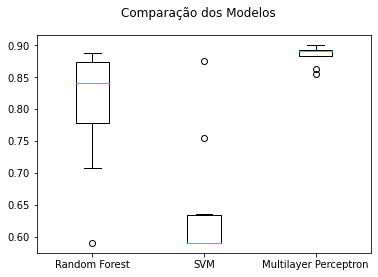

In [27]:
results = []
names = []
results.append(model_dict.get('rf').cv_results_['mean_test_score'])
results.append(model_dict.get('svm').cv_results_['mean_test_score'])
results.append(model_dict.get('mlp').cv_results_['mean_test_score'])

names.append('Random Forest')
names.append('SVM')
names.append('Multilayer Perceptron')

# Comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figures/'+descritores+'-Comparacao.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show()


# Validação Externa dos modelos

In [28]:
rf = model_dict.get('rf')
svm = model_dict.get('svm')
mlp = model_dict.get('mlp')

# predict probabilities
pred_prob_rf = rf.predict_proba(X_val_ext)
pred_prob_svm = svm.predict_proba(X_val_ext)
pred_prob_mlp = mlp.predict_proba(X_val_ext)

pred_rf = rf.predict(X_val_ext)
pred_svm = svm.predict(X_val_ext)
pred_mlp = mlp.predict(X_val_ext)

## Random Forest

In [29]:
model_rf_stats = validation(y_val_ext, X_val_ext, cross_val, rf)
model_rf_stats

5-fold External Cross Validation Statistical Characteristcs of QSAR models developed morgan



/home/note/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/note/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
morgan,0.61,0.81,0.81,0.85,0.81,0.75,0.81,0.83,1.00
morgan AD,0.82,0.88,0.99,0.95,0.78,0.93,0.94,0.97,0.35


### Dados Estatísticos

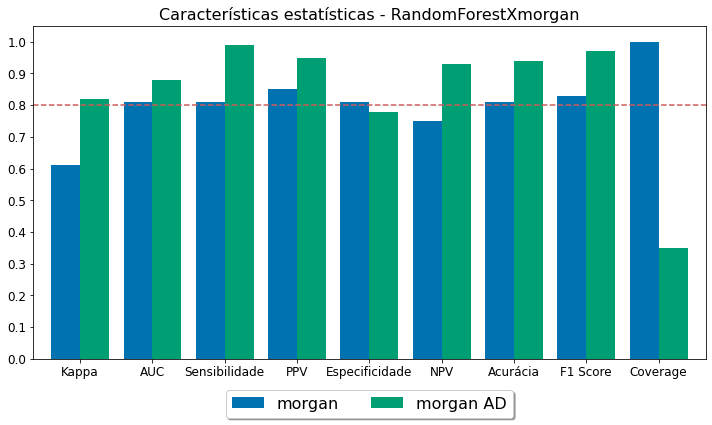

In [30]:
print_stats(model_rf_stats, descritores, 'RandomForest')

### Matriz de Confusão

confusion_matrix:
[[362  42]
 [ 98 464]]


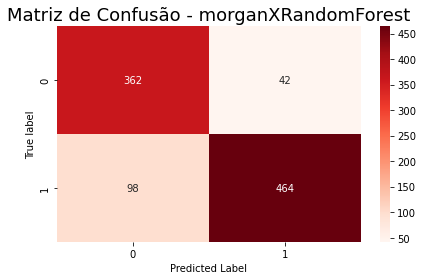

In [31]:
confusion_mtx(pred_rf, y_val_ext, 'RandomForest', descritores)

### Precisão X Recall

precisions:
[0.62653289 0.62611607 0.62681564 0.62751678 0.62821948 0.62892377
 0.62962963 0.63033708 0.63104612 0.63175676 0.632469   0.63318284
 0.63389831 0.63461538 0.63533409 0.63605442 0.63677639 0.6375
 0.63822526 0.63895216 0.63968073 0.64041096 0.64114286 0.64187643
 0.64261168 0.64408726 0.64482759 0.64556962 0.64631336 0.64705882
 0.647806   0.64855491 0.64930556 0.65005794 0.65081206 0.65156794
 0.65232558 0.65308498 0.65384615 0.6546091  0.65537383 0.65690867
 0.65767878 0.6584507  0.65922444 0.66       0.66077739 0.6615566
 0.66233766 0.66312057 0.66390533 0.66469194 0.66548043 0.66627078
 0.66706302 0.66785714 0.66865316 0.66945107 0.6702509  0.67105263
 0.67185629 0.67266187 0.67346939 0.67427885 0.67509025 0.67753623
 0.6783555  0.67917676 0.68       0.68082524 0.68165249 0.68248175
 0.68331303 0.68414634 0.68498168 0.68581907 0.68665851 0.6875
 0.68834356 0.68918919 0.6900369  0.6908867  0.69173859 0.69259259
 0.6934487  0.69430693 0.69516729 0.69602978 0.69689441 0.6

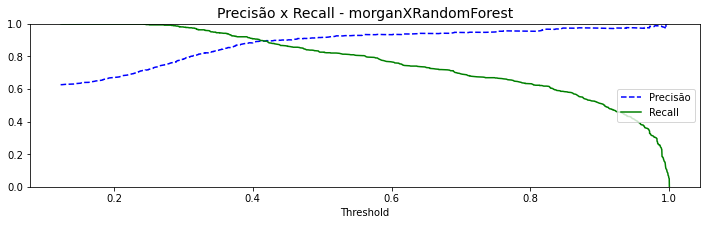

In [32]:
precisao_recall(pred_prob_rf, y_val_ext, 'RandomForest', descritores)

### Aleatorização da variável dependente Y

In [33]:
#y_randomization(rf, X_val_ext, y_val_ext, descritores, 'RandomForest', cross_val)

### Curva ROC

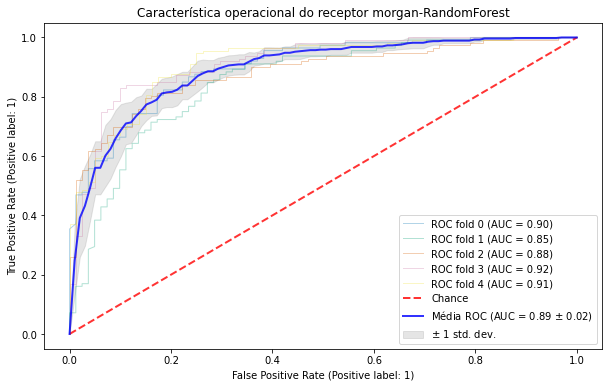

In [34]:
#roc_auc(rf, cross_val, X_val_ext, y_val_ext, 'RandomForest', descritores)

### Relatório de classificação do modelo

In [35]:
report(rf,y_val_ext, pred_rf, pred_prob_rf, 'RandomForest', descritores)

Relatório de Classificação - morganXRandomForest:
               precision    recall  f1-score   support

           0     0.7870    0.8960    0.8380       404
           1     0.9170    0.8256    0.8689       562

    accuracy                         0.8551       966
   macro avg     0.8520    0.8608    0.8534       966
weighted avg     0.8626    0.8551    0.8560       966

AUC: 0.9415



# SVM

In [36]:
model_svm_stats = validation(y_val_ext, X_val_ext, cross_val, svm)
model_svm_stats

5-fold External Cross Validation Statistical Characteristcs of QSAR models developed morgan



/home/note/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/note/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
morgan,0.59,0.79,0.84,0.82,0.74,0.77,0.80,0.83,1.00
morgan AD,0.76,0.88,0.93,0.91,0.83,0.86,0.89,0.92,0.63


### Dados Estatísticos

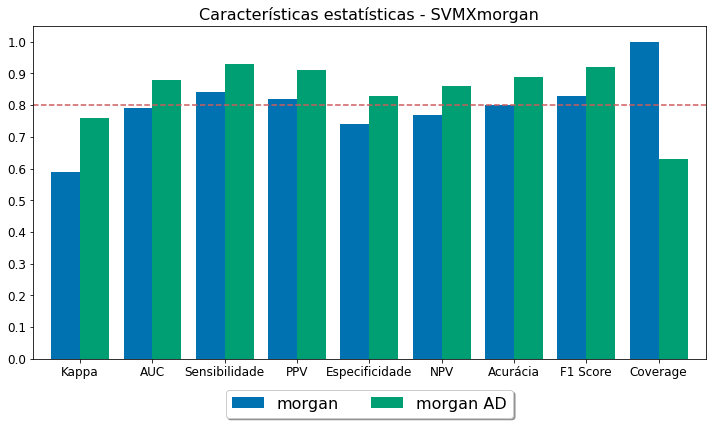

In [37]:
print_stats(model_svm_stats, descritores, 'SVM')

### Matriz de Confusão

confusion_matrix:
[[332  72]
 [ 67 495]]


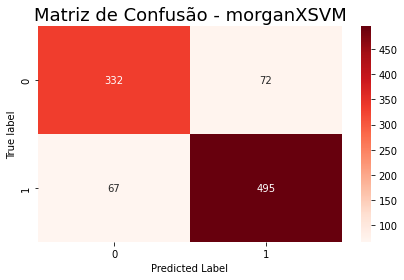

In [38]:
confusion_mtx(pred_svm, y_val_ext, 'SVM', descritores)

### Precisão X Recall

precisions:
[0.58971668 0.58928571 0.58990536 0.59052632 0.59114858 0.59177215
 0.59239704 0.59302326 0.59365079 0.59427966 0.59490986 0.5955414
 0.59617428 0.59680851 0.59744409 0.59701493 0.59765208 0.5982906
 0.59893048 0.59957173 0.60021436 0.60085837 0.60150376 0.60215054
 0.60279871 0.60344828 0.60409924 0.60475162 0.60540541 0.60606061
 0.60671723 0.60737527 0.60803474 0.60869565 0.609358   0.61002179
 0.61068702 0.61135371 0.61202186 0.61269147 0.61336254 0.61403509
 0.61470911 0.61538462 0.61606161 0.61674009 0.61742007 0.61810155
 0.61878453 0.61946903 0.62015504 0.62084257 0.62153163 0.62222222
 0.62291435 0.62360802 0.62430323 0.62388393 0.62458101 0.62527964
 0.62597984 0.62668161 0.62738496 0.62808989 0.6287964  0.62837838
 0.62908681 0.62979684 0.63050847 0.6300905  0.63080408 0.63151927
 0.6322361  0.63295455 0.63367463 0.63439636 0.63511973 0.63584475
 0.63657143 0.63729977 0.63802978 0.63761468 0.63834673 0.63793103
 0.63866513 0.63940092 0.64013841 0.6408776  0.64161

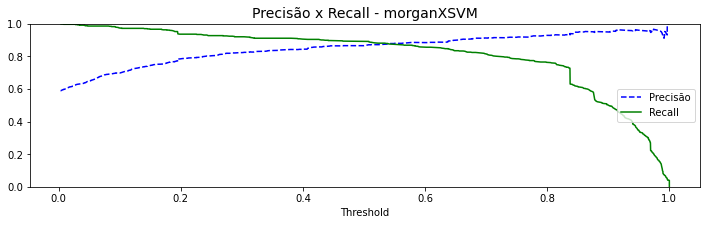

In [39]:
precisao_recall(pred_prob_svm, y_val_ext, 'SVM', descritores)

### Aleatorização da variável dependente Y

In [40]:
#y_randomization(svm, X_val_ext, y_val_ext, descritores, 'SVM', cross_val)

### Curva ROC

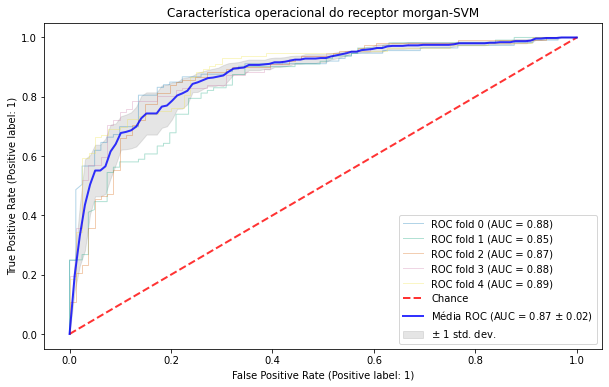

In [41]:
#roc_auc(svm, cross_val, X_val_ext, y_val_ext, 'SVM', descritores)

### Relatório de classificação do modelo

In [42]:
report(svm, y_val_ext, pred_svm, pred_prob_svm, 'SVM', descritores)

Relatório de Classificação - morganXSVM:
               precision    recall  f1-score   support

           0     0.8321    0.8218    0.8269       404
           1     0.8730    0.8808    0.8769       562

    accuracy                         0.8561       966
   macro avg     0.8525    0.8513    0.8519       966
weighted avg     0.8559    0.8561    0.8560       966

AUC: 0.9149



## MultiLayer perceptor

In [43]:
model_mlp_stats = validation(y_val_ext, X_val_ext, cross_val, mlp)
model_mlp_stats

5-fold External Cross Validation Statistical Characteristcs of QSAR models developed morgan



/home/note/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/note/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score,Coverage
morgan,0.64,0.82,0.86,0.85,0.78,0.80,0.83,0.85,1.00
morgan AD,0.73,0.86,0.91,0.88,0.81,0.86,0.87,0.89,0.78


### Dados Estatísticos

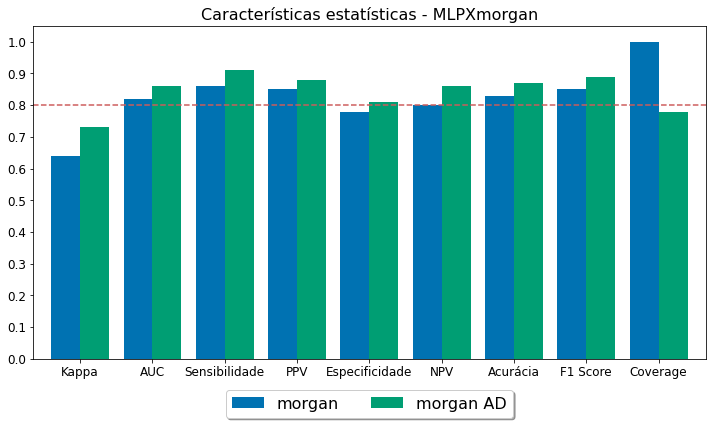

In [44]:
print_stats(model_mlp_stats, descritores, 'MLP')

### Matriz de Confusão

confusion_matrix:
[[354  50]
 [ 70 492]]


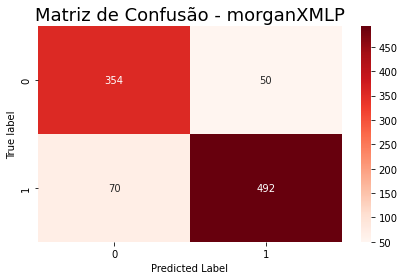

In [45]:
confusion_mtx(pred_mlp, y_val_ext, 'MLP', descritores)

### Precisão X Recall

precisions:
[0.59345301 0.59302326 0.59365079 0.59427966 0.59490986 0.5955414
 0.59617428 0.59680851 0.59744409 0.59808102 0.59871932 0.59935897
 0.6        0.6006424  0.60128617 0.60193133 0.60257787 0.60322581
 0.60387513 0.60452586 0.60517799 0.60583153 0.60648649 0.60714286
 0.60845987 0.60912052 0.60978261 0.61044614 0.61111111 0.61177754
 0.61244541 0.61311475 0.61378556 0.61445783 0.61403509 0.61470911
 0.61538462 0.61606161 0.61674009 0.61742007 0.61810155 0.61878453
 0.61946903 0.62015504 0.62084257 0.62153163 0.62222222 0.62291435
 0.62360802 0.62430323 0.625      0.62569832 0.62639821 0.62709966
 0.62780269 0.6285073  0.62921348 0.62992126 0.63063063 0.6313416
 0.63205418 0.63276836 0.63348416 0.63492063 0.63564132 0.63636364
 0.6370876  0.63781321 0.63854048 0.64       0.64073227 0.64146621
 0.64220183 0.64293915 0.64367816 0.64441887 0.64516129 0.64590542
 0.64665127 0.64739884 0.64814815 0.64889919 0.64965197 0.6504065
 0.65116279 0.65192084 0.65268065 0.65344224 0.654205

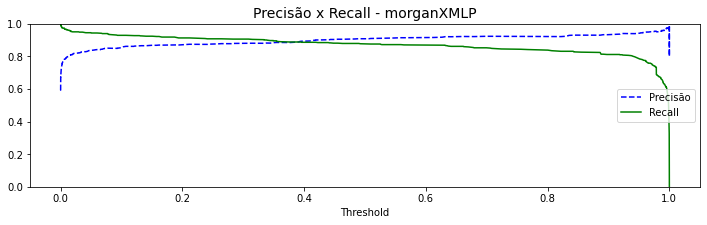

In [46]:
precisao_recall(pred_prob_mlp, y_val_ext, 'MLP', descritores)

### Aleatorização da variável dependente Y

In [47]:
#y_randomization(mlp, X_val_ext, y_val_ext, descritores, 'MLP', cross_val)

### Curva ROC

/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


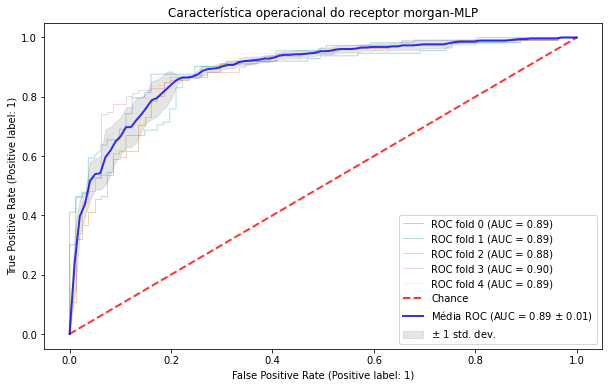

In [48]:
#roc_auc(mlp, cross_val, X_val_ext, y_val_ext, 'MLP', descritores)

### Relatório de classificação do modelo

In [49]:
report(mlp, y_val_ext, pred_mlp, pred_prob_mlp, 'MLP', descritores)

Relatório de Classificação - morganXMLP:
               precision    recall  f1-score   support

           0     0.8349    0.8762    0.8551       404
           1     0.9077    0.8754    0.8913       562

    accuracy                         0.8758       966
   macro avg     0.8713    0.8758    0.8732       966
weighted avg     0.8773    0.8758    0.8762       966

AUC: 0.9384



## Comparação - Área sob a curva ROC

Área sob a curva ROC - Random Forest: 0.9641
Área sob a curva ROC - SVM: 0.9859
Área sob a curva ROC - MLP: 0.9873


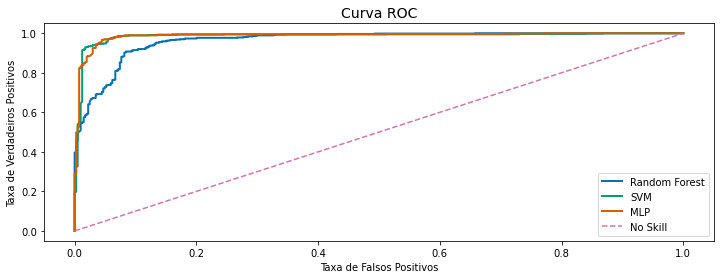

In [71]:
# predict probabilities
yhat_rf = rf.predict_proba(X_val_ext)
yhat_svm = svm.predict_proba(X_val_ext)
yhat_mlp = mlp.predict_proba(X_val_ext)

pos_probs_rf = yhat_rf[:, 1]
pos_probs_svm = yhat_svm[:, 1]
pos_probs_mlp = yhat_mlp[:, 1]


fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_val_ext, pos_probs_rf)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val_ext, pos_probs_svm)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_val_ext, pos_probs_mlp)

print('Área sob a curva ROC - Random Forest: {:.4f}'
      .format(roc_auc_score(y_val_ext, pos_probs_rf)))
print('Área sob a curva ROC - SVM: {:.4f}'
      .format(roc_auc_score(y_val_ext, pos_probs_svm)))
print('Área sob a curva ROC - MLP: {:.4f}'
      .format(roc_auc_score(y_val_ext, pos_probs_mlp)))


fig, ax = plt.subplots(figsize = (12,4))
plt.plot(fpr_forest, tpr_forest, linewidth=2, label = 'Random Forest')
plt.plot(fpr_svm, tpr_svm, linewidth=2, label = 'SVM')
plt.plot(fpr_mlp, tpr_mlp, linewidth=2, label = 'MLP')
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc = 'lower right')
plt.title('Curva ROC', fontsize = 14)
plt.savefig('figures/'+descritores+'-roc_comparison-'+descritores+'.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
plt.show()

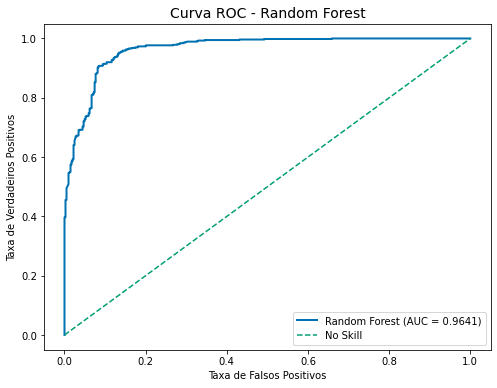

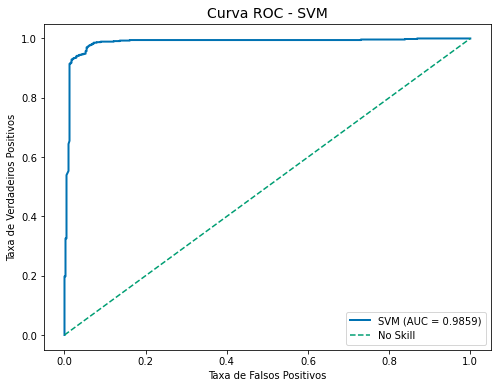

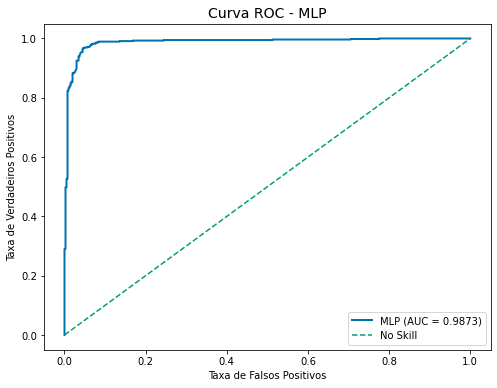

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_rf = roc_auc_score(y_val_ext, pos_probs_rf)
roc_auc_svm = roc_auc_score(y_val_ext, pos_probs_svm)
roc_auc_mlp = roc_auc_score(y_val_ext, pos_probs_mlp)

# Gráfico ROC para Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_forest, tpr_forest, linewidth=2, label='Random Forest (AUC = {:.4f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curva ROC - Random Forest', fontsize=14)
plt.savefig('figures/'+descritores+'-roc_comparison-random_forest.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
plt.show()

# Gráfico ROC para SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, linewidth=2, label='SVM (AUC = {:.4f})'.format(roc_auc_svm))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curva ROC - SVM', fontsize=14)
plt.savefig('figures/'+descritores+'-roc_comparison-svm.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
plt.show()

# Gráfico ROC para MLP
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, linewidth=2, label='MLP (AUC = {:.4f})'.format(roc_auc_mlp))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curva ROC - MLP', fontsize=14)
plt.savefig('figures/'+descritores+'-roc_comparison-mlp.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
plt.show()

## Deep learning QSAR

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [84]:
# Função para criar os gráficos de métricas clássicas de QSAR
def plot_qsar_metrics(y_true, y_pred_prob, algoritimo, descritores):
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig('figures/'+descritores+'X'+algoritimo+'roc-auc.png', bbox_inches='tight',
    transparent=False, format='png', dpi=300)
    plt.show()

    # Curva PR (Precision-Recall)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = average_precision_score(y_true, y_pred_prob)
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (area = {:.2f})'.format(pr_auc))
    plt.savefig('figures/'+descritores+'X'+algoritimo+'precision-recall.png', bbox_inches='tight',
    transparent=False, format='png', dpi=300)
    plt.show()

    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred_prob >= 0.5)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig('figures/'+descritores+'X'+algoritimo+'confusion-matrix.png', bbox_inches='tight',
    transparent=False, format='png', dpi=300)
    plt.show()

In [85]:
# Função para construir o modelo
def build_model(hp):
    model = keras.Sequential()
    
    # Ajuste o número de unidades na primeira camada densa
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units1, activation='relu', input_shape=(X_train.shape[1],)))
    
    # Ajuste o número de unidades na segunda camada densa
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units2, activation='relu'))
    
    # Ajuste a taxa de aprendizado para o otimizador
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    
    # Camada de saída para classificação binária
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [86]:
# Criar o tuner (ajuste)
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='dir_'+descritores,
    project_name='qsar_classification')

In [87]:
# Realizar a busca por hiperparâmetros
tuner.search(X_train, y_train, epochs=5, validation_split=0.2)


best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Melhores Hiperparâmetros:")
print(best_hyperparameters)


# Obter o melhor modelo
best_models = tuner.get_best_models(num_models=1)
print("Melhor Modelo:")
print(best_model.summary())  # Para exibir um resumo do modelo
best_models

Trial 5 Complete [00h 00m 13s]
val_accuracy: 0.8870202501614889

Best val_accuracy So Far: 0.9107373952865601
Total elapsed time: 00h 00m 53s
INFO:tensorflow:Oracle triggered exit
Melhores Hiperparâmetros:
Melhor Modelo:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               852384    
                                                                 
 dense_1 (Dense)             (None, 96)                40032     
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 892,513
Trainable params: 892,513
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
import os
# Salvar o melhor modelo em um arquivo H5
nome_arquivo = descritores+'_melhor_modelo.h5'
nome_diretorio = 'sequential_h5'
saved_model_path = os.path.join(f"{nome_diretorio}", f"{nome_arquivo}")
best_models[0].save(filepath=saved_model_path)    

In [89]:
# Carregar o melhor modelo
best_model = load_model(f"{nome_diretorio}/{nome_arquivo}")

In [90]:
# Avaliar o melhor modelo no conjunto de teste
test_loss, test_acc = best_model.evaluate(X_val_ext, y_val_ext)
print('Test accuracy:', test_acc)

31/31 [==============================] - 0s 2ms/step - loss: 0.4159 - accuracy: 0.8789
Test accuracy: 0.8788819909095764


In [91]:
# Prever as probabilidades no conjunto de teste
y_pred_prob = best_model.predict(X_val_ext)

31/31 [==============================] - 0s 2ms/step


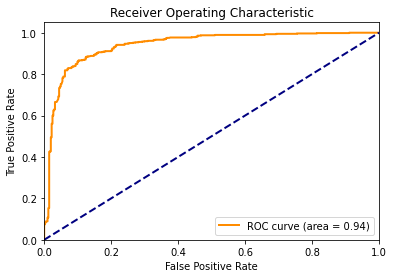

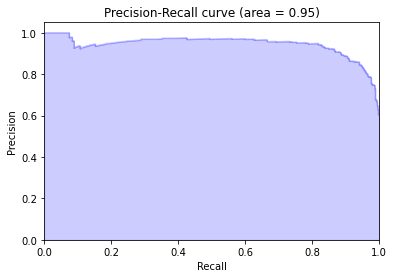

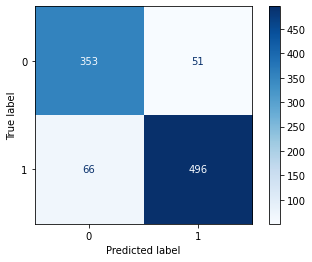

In [92]:
# Plotar as métricas clássicas de QSAR
plot_qsar_metrics(y_val_ext, y_pred_prob, 'sequential',descritores)

In [93]:
from sklearn import metrics

def statsDeep(y_test, y_pred):
    # Calcular as métricas usando um limiar de 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Calcular as métricas
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
    Kappa = metrics.cohen_kappa_score(y_test, y_pred, weights='linear')
    TN, FP, FN, TP = confusion_matrix.ravel()
    AC = (TP + TN) / (TP + FP + FN + TN)
    SE = TP / (TP + FN)
    SP = TN / (TN + FP)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    CCR = (SE + SP) / 2
    F1_score = 2 * (PPV * SE) / (PPV + SE)

    d = dict({'Kappa': Kappa,
              'AUC': CCR,
              'Sensibilidade': SE,
              'PPV': PPV,
              'Especificidade': SP,
              'NPV': NPV,
              'Acurácia': AC,
              'F1 Score': F1_score})

    return pd.DataFrame(d, columns=d.keys(), index=[0]).round(2)

In [94]:
model_keras_stats = statsDeep(y_val_ext,y_pred_prob)

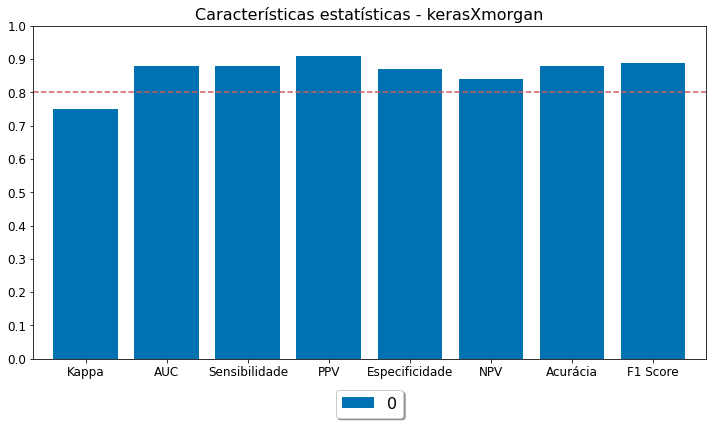

In [95]:
print_stats(model_keras_stats, descritores, 'keras')

In [96]:
model_keras_stats

,Kappa,AUC,Sensibilidade,PPV,Especificidade,NPV,Acurácia,F1 Score
0,0.75,0.88,0.88,0.91,0.87,0.84,0.88,0.89


## Comparação MORGAN

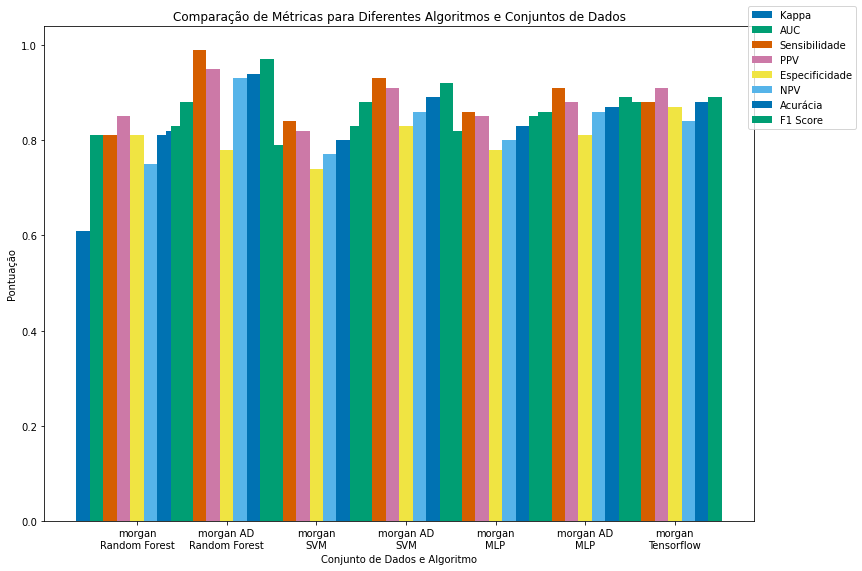

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
algorithms = ['Random Forest', 'Random Forest', 'SVM', 'SVM', 'MLP', 'MLP', 'Tensorflow']
datasets = ['morgan', 'morgan AD', 'morgan', 'morgan AD', 'morgan', 'morgan AD', 'morgan']
metrics = ['Kappa', 'AUC', 'Sensibilidade', 'PPV', 'Especificidade', 'NPV', 'Acurácia', 'F1 Score']

data = np.array([
    [0.61, 0.81, 0.81, 0.85, 0.81, 0.75, 0.81, 0.83],
    [0.82, 0.88, 0.99, 0.95, 0.78, 0.93, 0.94, 0.97],
    [0.59, 0.79, 0.84, 0.82, 0.74, 0.77, 0.80, 0.83],
    [0.76, 0.88, 0.93, 0.91, 0.83, 0.86, 0.89, 0.92],
    [0.64, 0.82, 0.86, 0.85, 0.78, 0.80, 0.83, 0.85],
    [0.73, 0.86, 0.91, 0.88, 0.81, 0.86, 0.87, 0.89],
    [0.75, 0.88, 0.88, 0.91, 0.87, 0.84, 0.88, 0.89]
])

# Preparando os dados para o gráfico
n_metrics = len(metrics)
width = 0.15
x = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(n_metrics):
    ax.bar(x + i * width, data[:, i], width, label=metrics[i])

ax.set_xlabel('Conjunto de Dados e Algoritmo')
ax.set_ylabel('Pontuação')
ax.set_title('Comparação de Métricas para Diferentes Algoritmos e Conjuntos de Dados')
ax.set_xticks(x + (n_metrics * width) / 2)
ax.set_xticklabels([f'{dataset}\n{algorithm}' for dataset, algorithm in zip(datasets, algorithms)])
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))

plt.tight_layout()
plt.show()

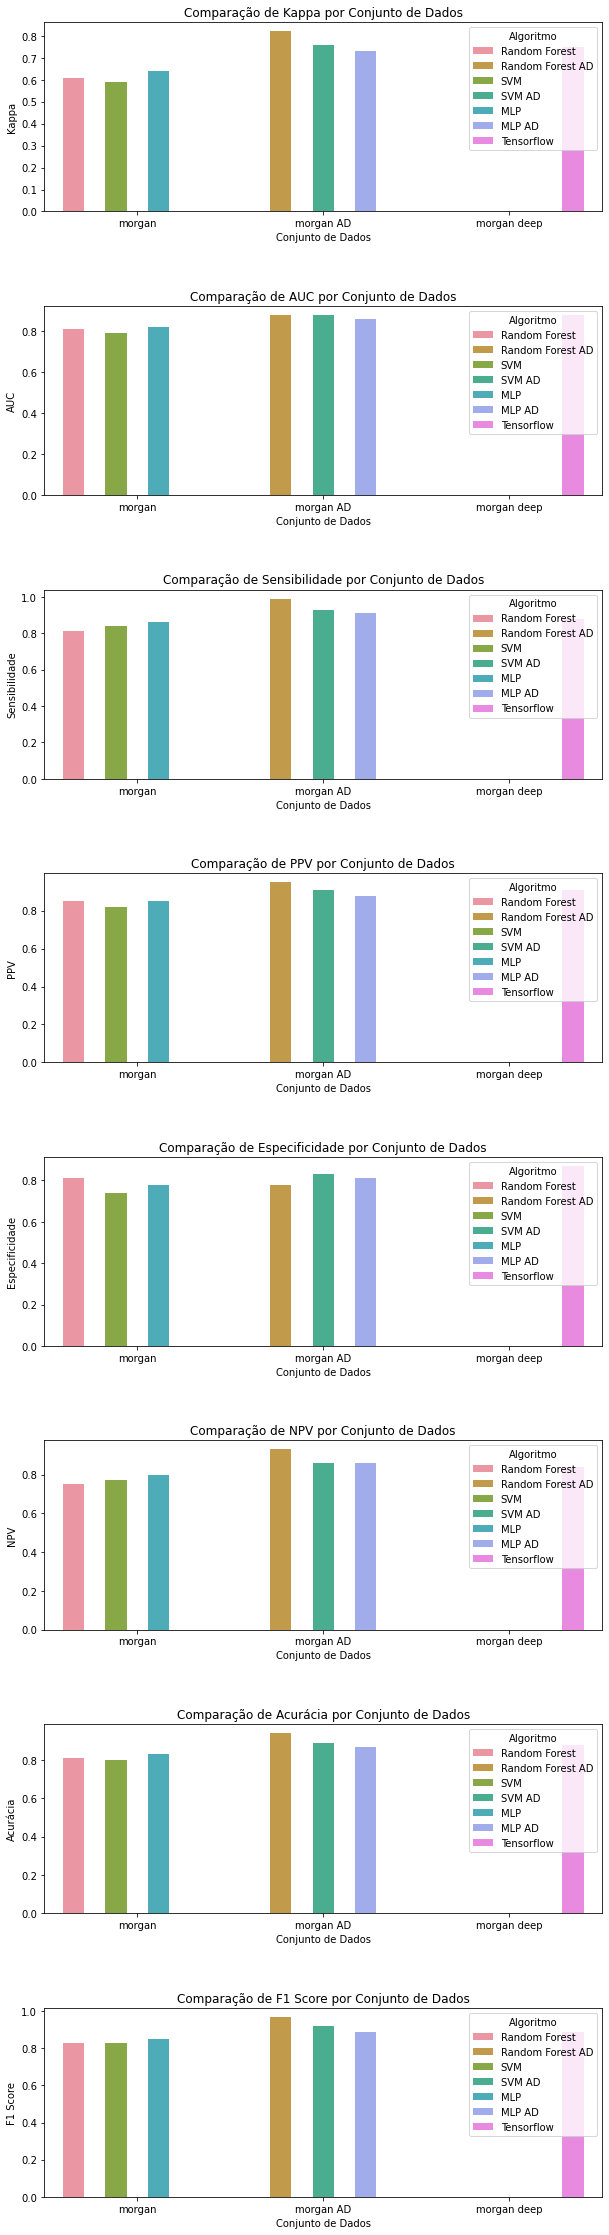

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Dados
data = {
    'Algoritmo': ['Random Forest', 'Random Forest AD', 'SVM', 'SVM AD', 'MLP', 'MLP AD', 'Tensorflow'],
    'Conjunto de Dados': ['morgan', 'morgan AD', 'morgan', 'morgan AD', 'morgan', 'morgan AD', 'morgan deep'],
    'Kappa': [0.61, 0.82, 0.59, 0.76, 0.64, 0.73, 0.75],
    'AUC': [0.81, 0.88, 0.79, 0.88, 0.82, 0.86, 0.88],
    'Sensibilidade': [0.81, 0.99, 0.84, 0.93, 0.86, 0.91, 0.88],
    'PPV': [0.85, 0.95, 0.82, 0.91, 0.85, 0.88, 0.91],
    'Especificidade': [0.81, 0.78, 0.74, 0.83, 0.78, 0.81, 0.87],
    'NPV': [0.75, 0.93, 0.77, 0.86, 0.80, 0.86, 0.84],
    'Acurácia': [0.81, 0.94, 0.80, 0.89, 0.83, 0.87, 0.88],
    'F1 Score': [0.83, 0.97, 0.83, 0.92, 0.85, 0.89, 0.89]
}

df = pd.DataFrame(data)

# Métricas a serem comparadas
metrics = ['Kappa', 'AUC', 'Sensibilidade', 'PPV', 'Especificidade', 'NPV', 'Acurácia', 'F1 Score']

# Criar subplots para cada métrica
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 5 * len(metrics)))
plt.subplots_adjust(hspace=0.5)

for i, metric in enumerate(metrics):
    sns.barplot(data=df, x='Conjunto de Dados', y=metric, hue='Algoritmo', ax=axes[i])
    axes[i].set_title(f'Comparação de {metric} por Conjunto de Dados')
    axes[i].set_xlabel('Conjunto de Dados')
    axes[i].set_ylabel(metric)
    axes[i].legend(title='Algoritmo')

plt.show()